# Problem Statement: **Optimization of AtliQ's Fashion Image Classifier**

### AtliQ Retail wants to develop a neural network model to classify fashion items from the **FashionMNIST** dataset. Your task is to optimize the model's performance by experimenting with different optimization algorithms.

Imports and CUDA

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda




---



**Step1**: Load and Sample the Dataset

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data',train=False,download=False,transform=transform)

train_subset_size =12000
test_subset_size =3000



---



**Step2**: Create Dataloaders

* batch size = 32

In [37]:
train_subset, _ = random_split(train_dataset, [train_subset_size, len(train_dataset) - train_subset_size])
test_subset, _ = random_split(test_dataset,[test_subset_size,len(test_dataset)-test_subset_size])

In [38]:
batch_size =32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset,batch_size=batch_size,shuffle=True)

torch.Size([32, 1, 28, 28]) torch.Size([32])


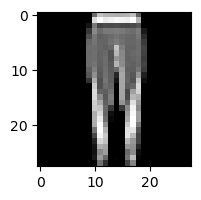

In [39]:
# Check a sample image in FashionMNIST Dataset
from matplotlib import pyplot as plt

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


plt.figure(figsize=(2,2))
plt.imshow(images[7].squeeze(), cmap='gray')
plt.show()



---



**Step3**: Define the Neural Network

* Create a fully connected feed-forward neural network (no CNN).

Structure:
* Input layer: 784 neurons (28x28 image flattened).
* 1st hidden layer: 128 neurons with ReLU activation.
* 2nd hidden layer: 64 neurons with ReLU activation.
* Output layer: 10 neurons (one for each class) with Softmax activation.
* Use `CrossEntropyLoss `as Loss Function

Use `nn.Sequential`

In [41]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN,self).__init__()
        self.network=nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
            
        )
    def forward(self,x):
        return self.network(x)
model=FashionNN().to(device='cuda')
print(model)

loss_fn=nn.CrossEntropyLoss()

FashionNN(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
    (6): Softmax(dim=None)
  )
)




---



**Step4**: Train and Evaluate with SGD

* set number of epochs to 10
* `lr` = 0.01
* momentum = 0.0




In [43]:
device='cuda'

In [45]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        optimizer_sgd.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_sgd.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with SGD optimizer: {accuracy:.2f}%")


Epoch 1/10, Loss: 1.7321
Epoch 2/10, Loss: 1.7218
Epoch 3/10, Loss: 1.7138
Epoch 4/10, Loss: 1.7077
Epoch 5/10, Loss: 1.7019
Epoch 6/10, Loss: 1.6976
Epoch 7/10, Loss: 1.6929
Epoch 8/10, Loss: 1.6894
Epoch 9/10, Loss: 1.6852
Epoch 10/10, Loss: 1.6807
Accuracy with SGD optimizer: 80.47%


In [48]:
# Plot predictions vs true labels for the first 9 images
model.eval()
with torch.no_grad():
    # Grab a batch of test data
    images=images.to(device)
    labels=labels.to(device)
    
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
    plt.figure(figsize=(8, 8))
    for i in range(25):
        images=images.to(device)
        labels=labels.to(device)
        
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)



---



**Step5**: Train with SGD and Momentum

* set number of epochs to 10
* `lr` = 0.01
* momentum = 0.9

In [51]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_momentum = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        
        optimizer_momentum.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_momentum.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with Momentum optimizer: {accuracy:.2f}%")


Epoch 1/10, Loss: 1.6079
Epoch 2/10, Loss: 1.6081
Epoch 3/10, Loss: 1.6019
Epoch 4/10, Loss: 1.5974
Epoch 5/10, Loss: 1.5981
Epoch 6/10, Loss: 1.5933
Epoch 7/10, Loss: 1.5916
Epoch 8/10, Loss: 1.5919
Epoch 9/10, Loss: 1.5905
Epoch 10/10, Loss: 1.5867
Accuracy with Momentum optimizer: 84.87%


In [67]:
# Plot predictions vs true labels for the first 9 images
model.eval()
with torch.no_grad():
     images=images.to(device)
     labels=labels.to(device)
    # Grab a batch of test data
     images, labels = next(iter(test_loader))
     outputs = model(images)
     _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
     plt.figure(figsize=(8, 8))
     for i in range(25):
        images=images.to(device)
        labels=labels.to(device)
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
        plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)



---



**Step6**: Training with RMS Prop

* set number of epochs to 10
* `lr` = 0.001
* alpha = 0.9

In [69]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_rms = optim.RMSprop(model.parameters(),lr=0.001,alpha=0.9)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        optimizer_rms.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer_rms.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss/len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with RMS optimizer: {accuracy:.2f}%")


c:\Users\nande\.conda\envs\myenv_cb_dl\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Loss: 1.6374
Epoch 2/10, Loss: 1.6278
Epoch 3/10, Loss: 1.6269
Epoch 4/10, Loss: 1.6193
Epoch 5/10, Loss: 1.6211
Epoch 6/10, Loss: 1.6138
Epoch 7/10, Loss: 1.6206
Epoch 8/10, Loss: 1.6111
Epoch 9/10, Loss: 1.6156
Epoch 10/10, Loss: 1.6119
Accuracy with RMS optimizer: 81.37%


In [70]:
# Set number of epochs
num_epochs = 10

# Initialize the optimizer
optimizer_rms = optim.Adam(model.parameters(),lr=0.001)

# Store loss for each epoch
epoch_losses = []

# Train the model for num_epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images=images.to(device)
        labels=labels.to(device)
        optimizer_rms.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer_rms.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss/len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Step 2: Calculate accuracy after all epochs
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy with adam optimizer: {accuracy:.2f}%")


c:\Users\nande\.conda\envs\myenv_cb_dl\lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10, Loss: 1.6126
Epoch 2/10, Loss: 1.6117
Epoch 3/10, Loss: 1.6126
Epoch 4/10, Loss: 1.6131
Epoch 5/10, Loss: 1.6068
Epoch 6/10, Loss: 1.6042
Epoch 7/10, Loss: 1.6167
Epoch 8/10, Loss: 1.6089
Epoch 9/10, Loss: 1.6065
Epoch 10/10, Loss: 1.6003
Accuracy with adam optimizer: 85.00%


In [73]:
# Plot predictions vs true labels for the first 9 images
model.eval()
images=images.to(device)
labels=labels.to(device)
        
with torch.no_grad():
    # Grab a batch of test data
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # Plot the first 9 images with predictions and true labels
    plt.figure(figsize=(8, 8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        plt.axis('off')
    plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)



---

